# phospho quickstart

In this quickstart, we will use the `lab` from the `phospho` package to figure out how many messages in a dataset are questions.

1. First, we will detect events on a subset of the dataset using a pipeline powered by OpenAI GPT 3.5

2. Then, we will scale analytics with the `lab` optimizer. We will compare the event detection pipeline using MistralAI and a local Ollama model, and pick the best one in term of performance, speed and price.

3. Finally, we will use the `lab` to run the best model on the full dataset and visualize the results.

This way, we will be able to run semantic analytics at scale on a dataset using LLMs.


In [1]:
!pip install -q python-dotenv "phospho[lab]" 

In [1]:
# Load and check env variables
from dotenv import load_dotenv

load_dotenv()

from phospho import config

assert (
    config.OPENAI_API_KEY is not None
), "You need to set the OPENAI_API_KEY environment variable"

## Setup the Event detection pipeline

In phospho, there are two important concepts:

- A workload, which is a set of jobs. Those jobs are run asynchronously and in parallel.
- A job, which is a python function that returns a JobResult. Jobs are parametrized with a JobConfig.

In this example, the Job is to detect an event ("Event Detection") using LLM self-reflection (we asked another LLM whether the event occured or not). We will try to detect the event: "The user asks a question to the assistant".


In [2]:
from phospho import lab

# Create a workload in our lab
workload = lab.Workload()

# Add our job to the workload
workload.add_job(
    lab.Job(
        name="event_detection",
        id="question_answering",
        config=lab.EventConfig(
            event_name="Question Answering",
            event_description="User asks a question to the assistant",
            model="openai:gpt-3.5-turbo",
        ),
    )
)

Now that everything is set up, we can run the pipeline on a Message.

We want to detect whether the user asks a question. Sometimes, it's easy: there is a question mark. But sometimes, it's not: you understand that it is a question only through context and semantics. That's why you need an LLM.


In [3]:
await workload.async_run(
    messages=[
        # This message is a question, very simple to detect.
        lab.Message(
            id="message_1",
            content="What is the capital of France?",
        ),
        # This message is not a question, so it should not be detected.
        lab.Message(
            id="message_2",
            content="I don't like croissants.",
        ),
        # This message is also a question, but it lacks a question mark. You need semantics to detect it.
        lab.Message(
            id="message_3",
            content="I wonder what's the capital of France...",
        ),
    ]
)

for i in range(1, 4):
    print(
        f"In message {i}, the Event question answering was detected: {workload.results['message_'+str(i)]['question_answering'].value}"
    )

In message 1, the Event question answering was detected: True
In message 2, the Event question answering was detected: False
In message 3, the Event question answering was detected: True


# Dataset analytics

Now, let's assume we want to find user questions in a large dataset. How would we do it?

Let's load a dataset of messages from huggingface.


In [4]:
!pip install -q datasets

In [5]:
from datasets import load_dataset

dataset = load_dataset("daily_dialog")

/Users/nicolasoulianov/anaconda3/envs/phospho-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


This dataset has more than 10 000 samples. That's a lot and running analytics on it can quickly become pricy. So let's just select a subsample of it.


In [6]:
dataset["train"]

Dataset({
    features: ['dialog', 'act', 'emotion'],
    num_rows: 11118
})

In [7]:
# Generate a sub dataset with 30 messages
sub_dataset = dataset["train"].select(range(30))

# Let's print one of the messages
print(sub_dataset[0]["dialog"][0])

# Build the message list for our lab
messages = []
for row in sub_dataset:
    text = row["dialog"][0]
    messages.append(lab.Message(content=text))

Say , Jim , how about going for a few beers after dinner ? 


Now, let's run the analytics pipeline on the subset.

The workload run is **asynchronous** and **parallelized**, which means this will go much faster than just writing a for loop.


In [10]:
# Run the lab on it
# The job will be run with the default model (openai:gpt-3.5-turbo)
workload_results = await workload.async_run(messages=messages)

In [11]:
# Print the results
for message_id, jobs in workload_results.items():
    print(f"Message {message_id} was a question: {jobs['question_answering'].value}")

Message 23b0aa7c1f134208b280acbe6a244ede was a question: False
Message 344a2c917fc24e71b7ae23c624d59e14 was a question: True
Message 2cce5553503d4c08a0711659b9922523 was a question: True
Message 6a9d429d811c4a2881170a2baee1b67a was a question: False
Message e102b2e413054470a4700a2a4f8f5b06 was a question: False
Message 8d8e544d122746ac995b6cb340581e84 was a question: True
Message a94f4697fb884d66baec0e4f4b59a2f9 was a question: False
Message 4601a36a85cb4fd29f9b7d90dcb1cf6e was a question: False
Message 4c5f8dc4991147f1ac23c6b098dbaafa was a question: False
Message 5f3ff3adb3ea40f0aa81da9156dffc50 was a question: True
Message f9952fa16d594d50bf35bd52474b5122 was a question: True
Message 82d98dc65d084396aaf07bf8c0d8571e was a question: False
Message 7a18c5a2e529459fa53140bef2fa4de3 was a question: False
Message 4581cfbdf1354182a82e82c879ca672a was a question: True
Message 37f1f7ebda884a4a897a8129e56be57d was a question: False
Message cb4672258f5c4f53ae51bddf134ff49b was a question: Fals

## Optimize the pipeline

Running semantic analytics with an LLM is great. But it's expensive and slow.

You likely want to try other model providers, such as Mistral, or even small local models. But how do they compare?

Let's run the pipeline on these models, and then figure out which one matches the reference, GPT-4.

For the purpose of this demo, we consider a considertion good enough if it matches gpt-4 on at least 80% of the dataset. Good old Paretto.

### Installation and setup

You will need:

- a Mistral AI API key (find yours [here](https://console.mistral.ai/api-keys/))
- Ollama running on your local machine, with the Mistral 7B model installed. You can find the installation instructions for Ollama [here](https://ollama.com)


In [12]:
from phospho import config

# Check the environment variable
assert (
    config.MISTRAL_API_KEY is not None
), "You need to set the MISTRAL_API_KEY environment variable"

In [13]:
from phospho.lab.language_models import get_sync_client

# Create a client
ollama = get_sync_client("ollama")

try:
    # Let's check we can reach your local Ollama API
    response = ollama.chat.completions.create(
        model="mistral",
        messages=[
            {
                "role": "user",
                "content": "What is the best French cheese? Keep your answer short.",
            },
        ],
    )
    print(response.choices[0].message.content)
except Exception as e:
    print(f"Error: {e}")
    print(
        "You need to have a local Ollama server running to continue and the mistral model downloaded. \nRemove references to Ollama otherwise."
    )


"Camembert."


### Compute the results with the alternative configurations

To run the jobs on multiple models at the same time, we will simply set up our job with a different configuration.


In [18]:
from typing import Literal

workload = lab.Workload()


# Setup the configs for our job
class EventConfig(lab.JobConfig):
    event_name: str = "Question Answering"
    event_description: str = "User asks a question to the assistant"
    # Model are ordered from the least desired to the most desired
    # The default model is set to be the "reference"
    model: Literal[
        "openai:gpt-4",
        "mistral:mistral-large-latest",
        "mistral:mistral-small-latest",
        "ollama:mistral",
    ] = "openai:gpt-4"


# Add our job to the workload
workload.add_job(
    lab.Job(
        name="event_detection",
        id="question_answering",
        config=EventConfig(),
    )
)

We run the workload in the same way.


In [19]:
workload_results = await workload.async_run(messages=messages, executor_type="parallel")

In [20]:
# Note the default model is currently set to "openai:gpt-4"
workload.jobs[0].config.model

'openai:gpt-4'

Now, let's also run the pipeline on alternative models.


In [21]:
# Compute alternative results with the Mistral API and Ollama
await workload.async_run_on_alternative_configurations(
    messages=messages, executor_type="parallel"
)

We ask the workload to figure out which model is better.

Note that this can actually work with any set of parameters, not just models. It's a flexible way to perform a grid search.


In [22]:
workload.optimize_jobs(accuracy_threshold=0.8)

accuracies: [0.8333333333333334, 0.8, 0.5666666666666667]


Let's check what model was picked.


In [23]:
# let's check the new model_id (if it has changed)
workload.jobs[0].config.model

'mistral:mistral-small-latest'

Interesting! We can run our pipeline with roughly the same accuracy using a smaller model. That's a lot of time, compute and money saved.


## Run our workload on the full dataset, with optimized parameters

Now that we have benchmarked different models for our Event detection pipeline, let's run the optimal configuration on a larger chunk of the dataset.


In [24]:
sub_dataset = dataset["train"].select(
    range(200)
)  # Here you can just leave it as dataset["train"] if you want to use the whole dataset

# Build the message list for our lab
messages = []
for row in sub_dataset:
    text = row["dialog"][0]
    messages.append(lab.Message(content=text))

We want to run the evals on a lot of messages in parallel. However, if we just bombarded the model provider API, we'd have a **rate limit error.**

Indeed, each model provider has their own limitation. For Mistral, it's 5 requests per second max per default.

In order to avoid that, **we set a throttle of maximum 5 requests per second** using the parameter `max_parallelism`.

In [26]:
# The job will be runned with the best model (mistral:mistral-small-latest in our case)
workload_results = await workload.async_run(
    messages=messages,
    executor_type="parallel",
    max_parallelism=5,
)

## Analyze the results

Now, we were trying to see which share of the dataset is actually a question. Let's get the results as a dataframe and visualize them.


In [27]:
# Using .results_df() we can get a pandas dataframe with the results
workload.results_df()

,question_answering
e4c6e973db4a4eebacaa2befab6a7d50,False
6228b270d2ae4689bf78902e3481eb99,False
7a59050473174537866186f32dcbdfd8,True
bb287be6b48a4425b08e402c89bc6944,False
f561e8350af148949c21e8ea2dec7764,False
...,...
278bcbca28f34614af78be0c98219300,True
54ce64aa30f847c48dab8d36932f9cf2,True
dd37341a5410418393722b54f671a5a9,True
083b8d38700f4b92b3b177ee7d4663ac,True


We can see that there are many questions in this dataset...


In [28]:
workload.results_df().groupby("question_answering").size()

question_answering
False    108
True      92
dtype: int64

Let's make a nice plot.


In [29]:
!pip install -q matplotlib

<Axes: xlabel='question_answering'>

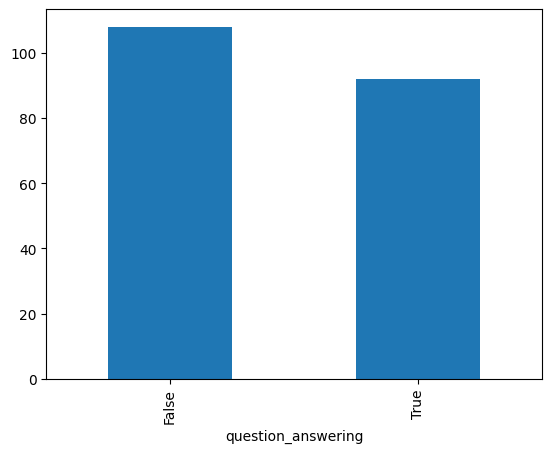

In [30]:
workload.results_df().groupby("question_answering").size().plot(kind="bar")

## Going further

You can use the `lab` to run other tasks, such as:

- Named Entity Recognition
- Sentiment Analysis
- Evaluations
- And more!

You can also play around with differnet models, different hyperparameters, and different datasets.

You want to have such analysis on your own LLM app, in real time? Check out the cloud hosted version of phospho, available on [phospho.ai](https://phospho.ai)
